## Задача матчинга
Представленны 2 множества объектов. Каждый объект в множества описывается какими-то признаками. 

**Необходимо** разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base

**Данные:**
- датасет base (для поиска схожих позиций)
- train (тренировка модели)
- validatin (проверка работоспособности)

**План работ:**
- Исследование данных
- Подготовка данных
- Поиск и тестирование лучшей модели





In [1]:
# !pip install faiss-cpu

# 1. Исследование данных

In [2]:
# Подгрузим основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import faiss
from sklearn.preprocessing import StandardScaler



In [3]:
# грузим датасеты
try:
    df_base = pd.read_csv("base.csv", index_col = 0)
    df_train = pd.read_csv("train.csv", index_col=0)
    df_valid = pd.read_csv('validation.csv', index_col=0)
    df_valid_target = pd.read_csv('validation_answer.csv', index_col=0)
except:
    df_base = pd.read_csv(".base.csv", index_col = 0)
    df_valid = pd.read_csv('/validation.csv', index_col=0)
    df_valid_target = pd.read_csv('/validation_answer.csv', index_col=0)
    df_train = pd.read_csv(".train.csv", index_col=0)

In [4]:
# проверка что всё загружено
display(df_base)
display(df_train)
display(df_valid)
display(df_valid_target)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.666340,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.202110,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.566180,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.202890,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.766320,-2.505783,65.315285,135.051590,-1074.464888,0.319401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744755-base,-125.086300,4.735448,38.284935,-125.27671,209.788360,-47.870010,-628.127378,-71.077340,125.534355,29.341850,...,-70.364395,55.428260,-191.53702,122.978279,65.515260,108.963715,-52.795380,117.254510,-615.998268,-77.768555
4744759-base,-108.598390,5.454173,-22.191975,-158.71666,113.606110,-88.843430,-117.234538,137.317690,129.056690,164.754240,...,-70.360190,18.439003,-90.65145,-28.586794,68.691666,1.636499,-24.388298,93.530540,-1074.464888,-90.800400
4744762-base,-97.026730,-2.143885,-71.274090,-144.68066,149.464810,-21.572212,-759.626065,-108.151955,124.810135,118.760700,...,-55.961933,62.923470,-169.11832,108.452806,68.592970,43.205433,69.029830,129.536650,-1074.464888,4.718300


,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936680,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.802570,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.260390,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.697710,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.401980,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.146200,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.416750,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052540,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.092070,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995-query,-68.180530,11.657515,-63.179720,-188.726530,131.113100,-65.125340,-514.276885,95.990750,118.761185,-5.635696,...,38.573555,-133.087130,14.040794,66.477340,-36.148730,61.689774,107.037950,-1074.464888,-35.128250,811868-base
99996-query,-66.540890,2.201112,-70.292114,-146.167850,77.817140,-47.525654,-118.994688,-25.183374,131.499820,183.260880,...,33.324960,-110.576416,-84.448525,65.818100,-30.268772,133.784000,154.495860,-1144.590904,-108.663510,1460772-base
99997-query,-53.948240,4.726887,-29.278950,-147.182830,264.090670,-101.135630,-427.544045,68.057560,118.084310,192.449250,...,-14.146965,-184.663830,22.971385,67.347800,110.437100,35.785603,111.616710,-714.897734,-4.270569,2366140-base


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926790,110.745940,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.513020,52.830902,-143.43945,59.051935,69.28224,61.927513,111.592530,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.417620,114.449910,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.441830,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.077160,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.160930,96.446160,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.795410,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.636410,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.060440,83.697080,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.236110,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.183960,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.884950,165.453920,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.770250,45.635944,-134.25893,13.735359,70.61763,15.332115,154.568120,101.700640,-1171.892332,-125.307890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995-query,-46.672780,6.644193,7.376480,-116.126400,80.031715,-48.248695,-17.696937,108.150240,122.729744,103.643906,...,-65.641110,62.823895,-148.86781,-66.402868,66.99333,76.524155,66.525670,112.273720,-177.375834,-82.804726
199996-query,-94.786316,10.852646,13.700245,-125.619385,21.545967,-89.625534,79.880236,-46.513206,123.578730,74.033020,...,-65.032900,38.019740,-113.62750,-18.436499,64.16223,-117.032380,94.026490,86.279526,-1271.502930,-63.491104
199997-query,-59.224453,13.585838,22.655106,-134.926030,145.205690,-63.278100,-109.805058,16.277431,128.150040,168.835420,...,-48.826626,39.679783,-149.33646,160.609919,71.55922,25.237282,-35.985450,97.924790,73.080770,-28.081186


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base
...,...
199995-query,967418-base
199996-query,1344948-base
199997-query,1690782-base


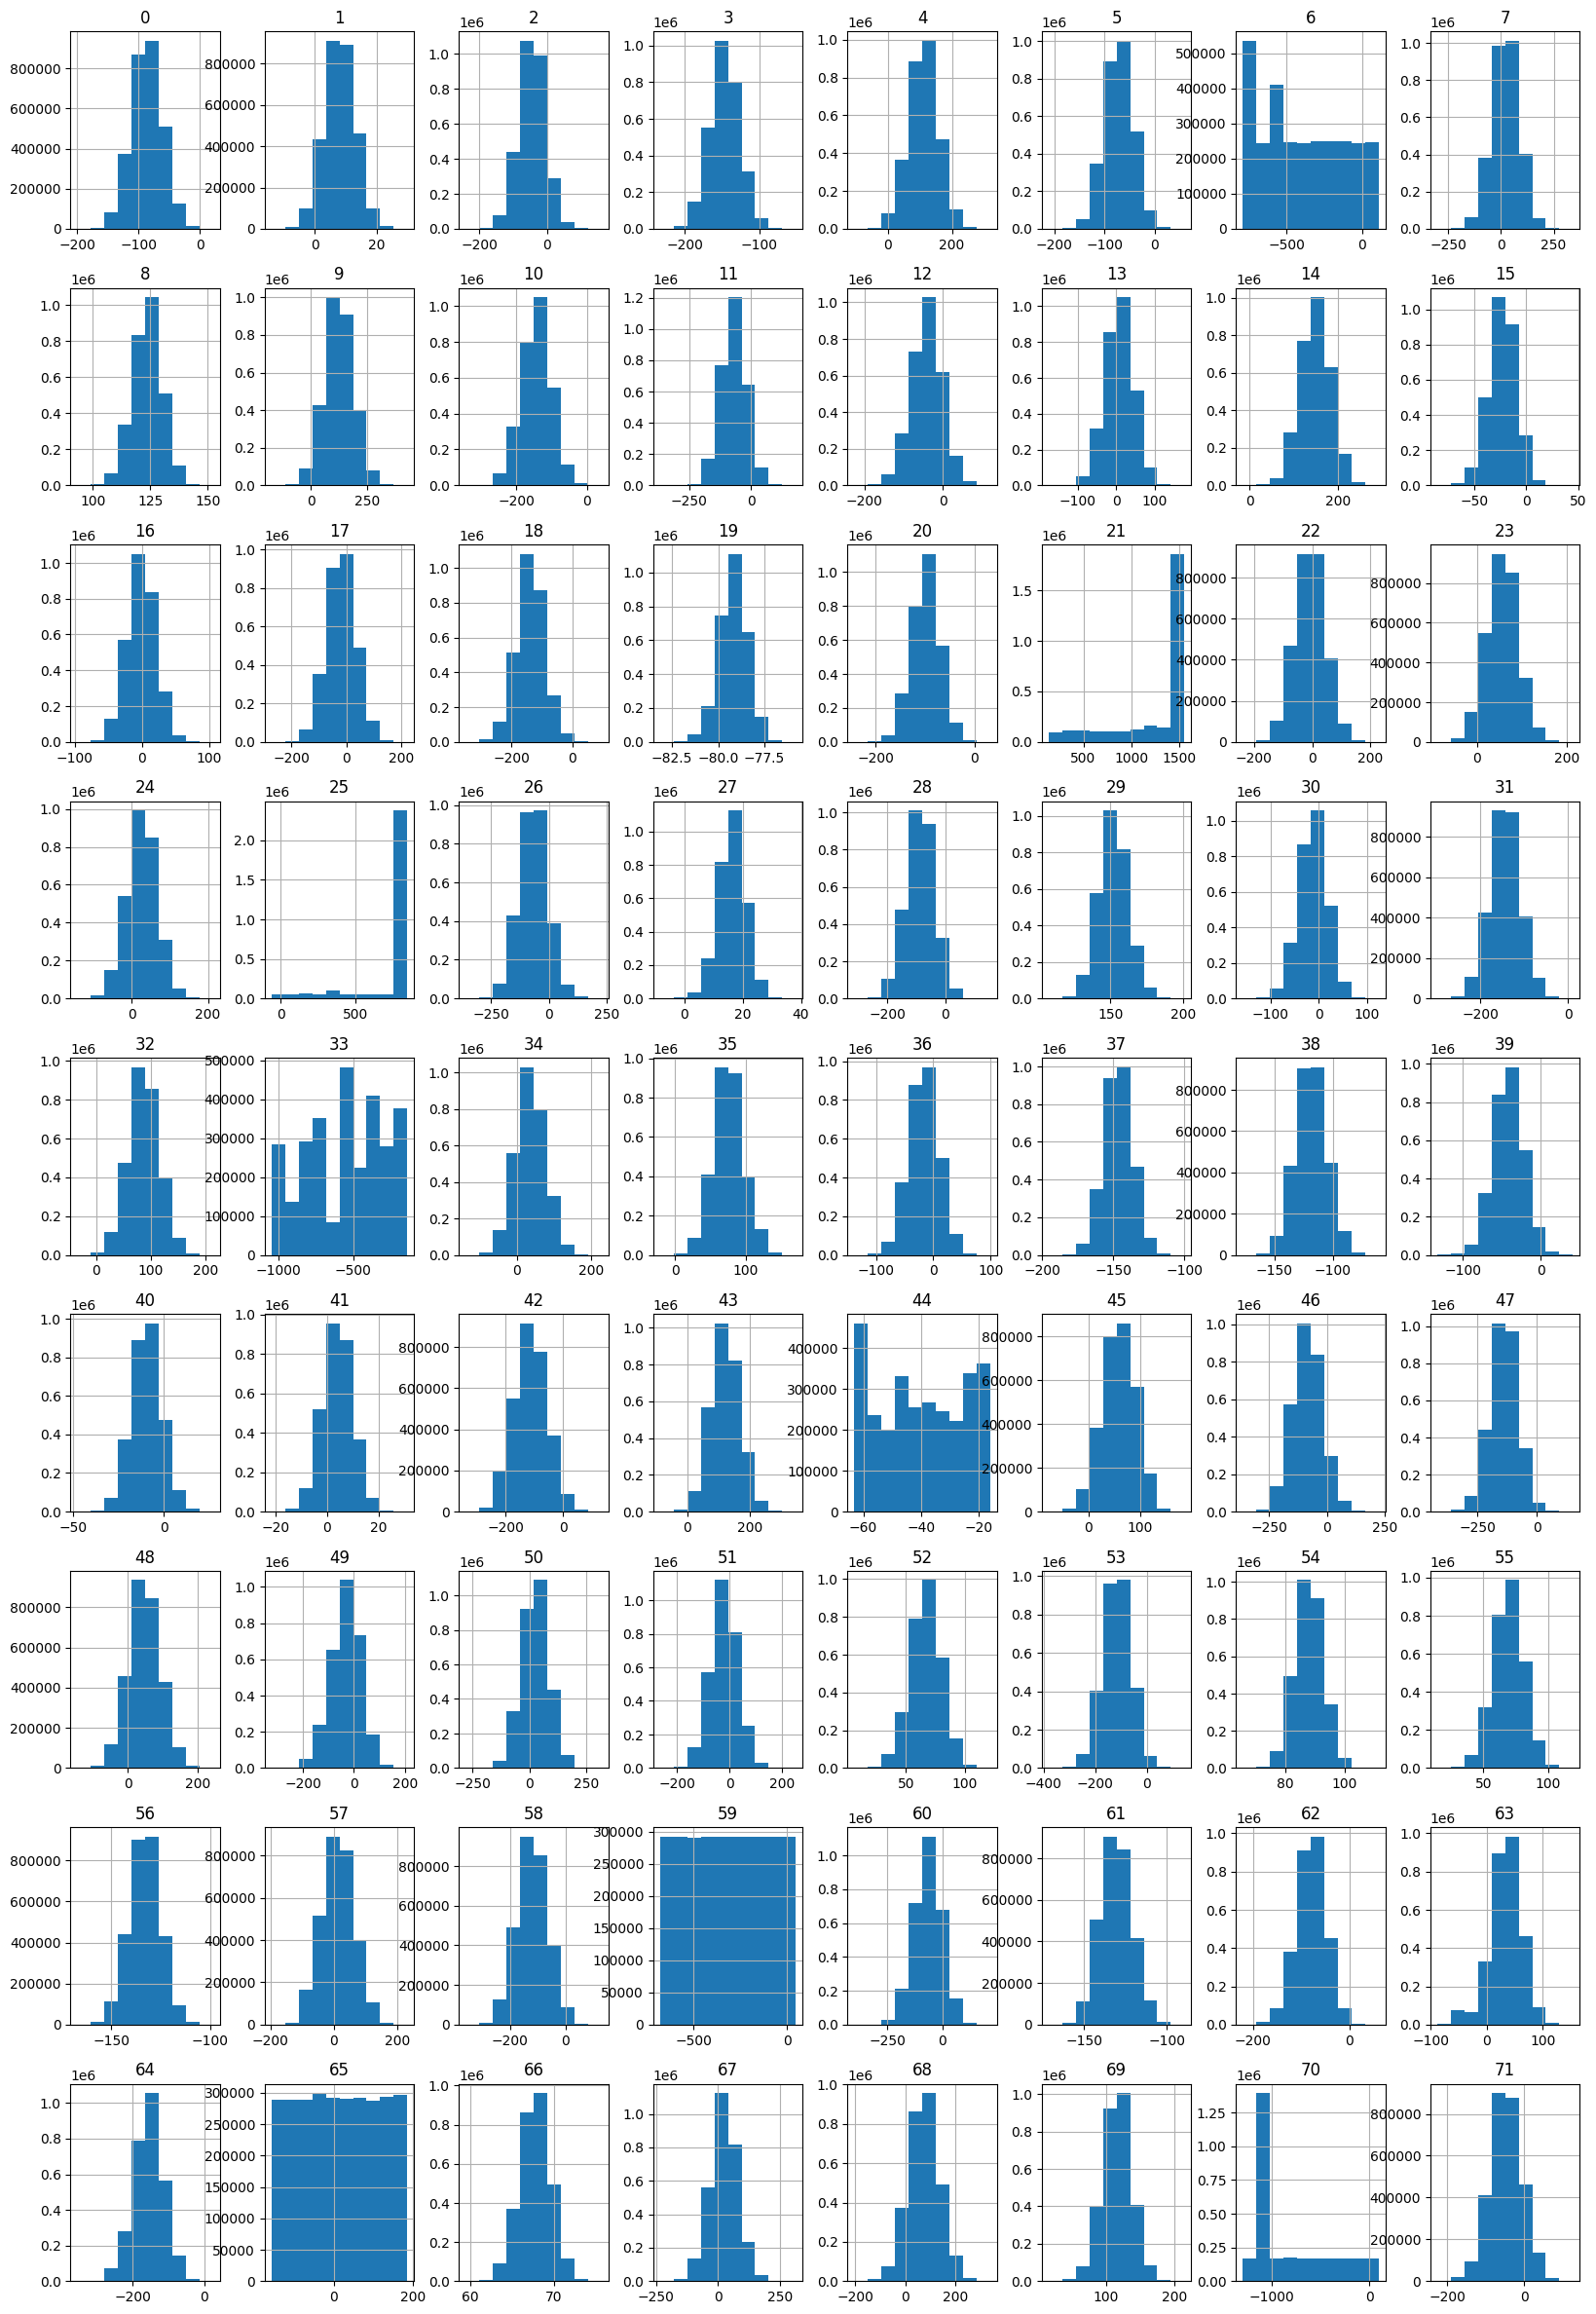

In [5]:
# просмотр распределения значений по колонкам
df_base.hist(figsize = (20,30))
plt.show()

In [6]:
def matrix_cor(data):
    '''функция создания матрицы корреляции'''
    plt.figure(figsize = (50,50))
    sns.set(font_scale = 1.4)
    cor_matrix = round(data.corr(),1)
    sns.heatmap(cor_matrix, annot = True, linewidths = .5, cmap = 'coolwarm')

    plt.title("Матрица корреляции числовых признаков")
    plt.show()

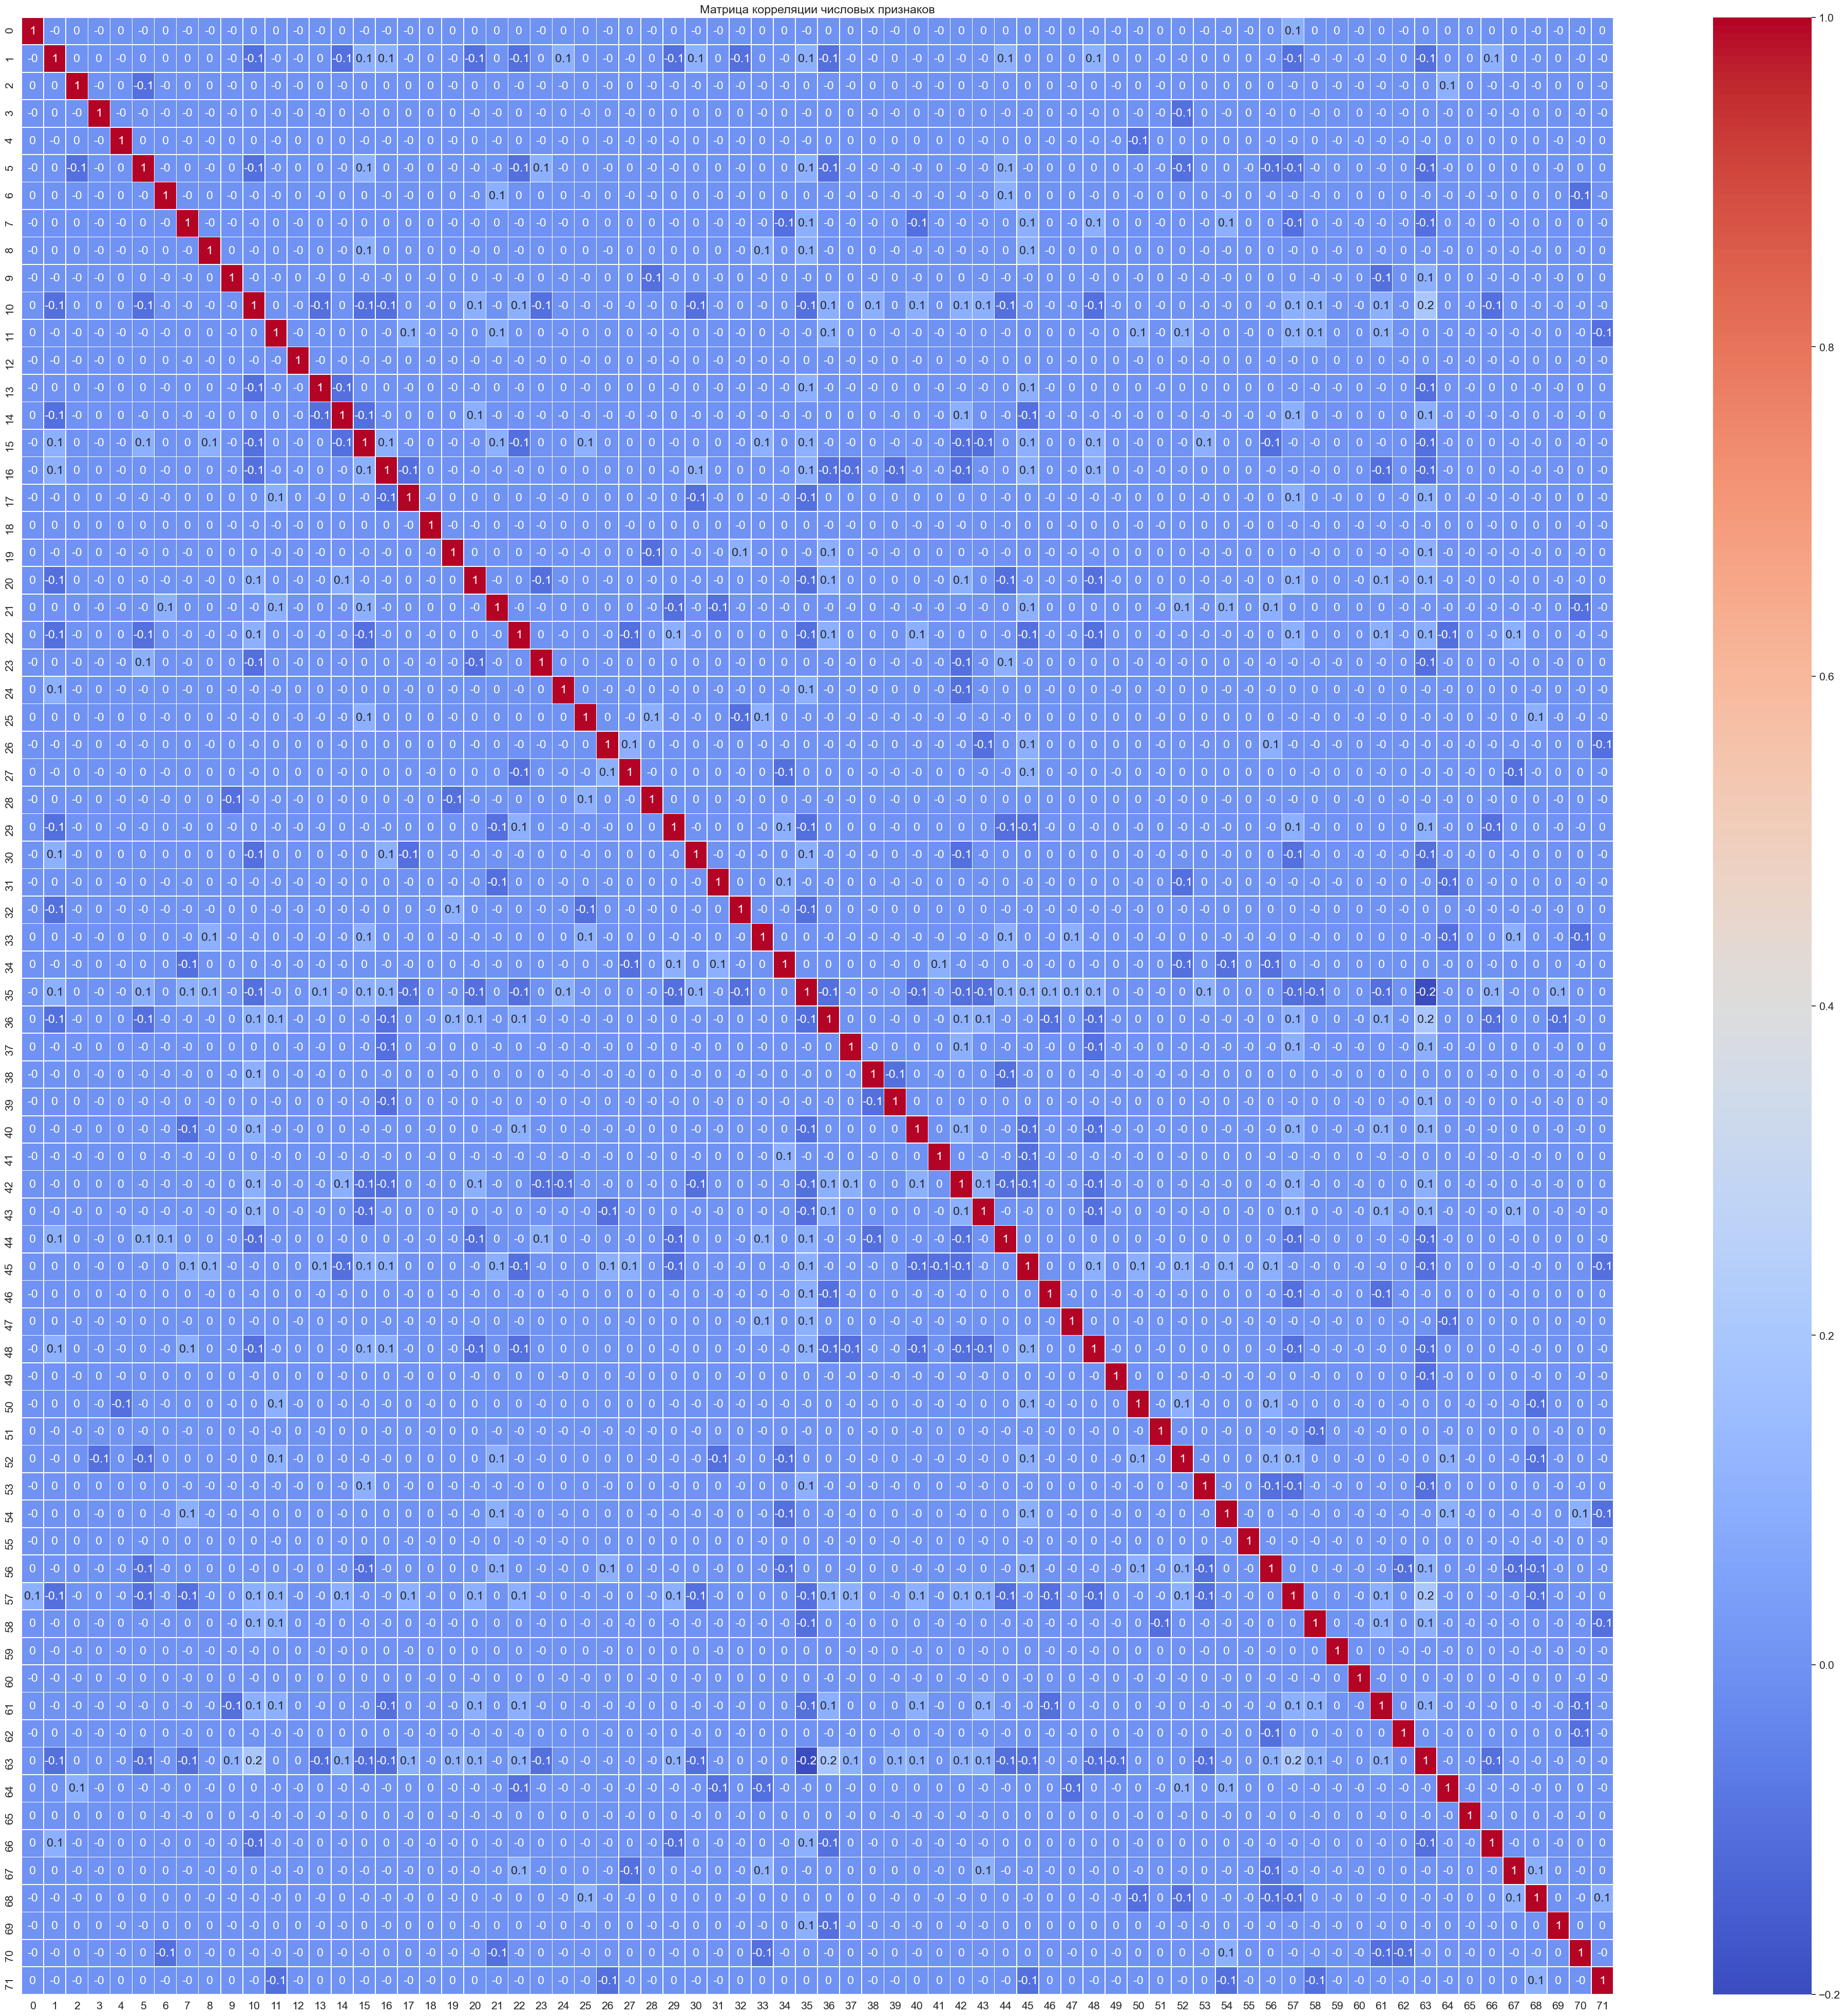

In [7]:
matrix_cor(df_base)

**Вывод:** Датасет для поиска состоит из более 2 млн. и 71 колонки. При исследовании распределения значений были выявлены равномерные значения. Для разбиения датасеты на кластеры это может снизить метрику качества, поэтому удалим в следующем пункте подобные столюбцы. 

## 2. Подготовка данных

In [8]:
# сохраним списко колонок
num_features = df_base.columns
num_features

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

In [9]:
%%time
# перекодировка данных

#скелер
scaler = StandardScaler()

# обучаем его
df_base[num_features] = scaler.fit_transform(df_base[num_features])

# скелером масштабируем тренировочную выборку
df_train[num_features] = scaler.transform(
        df_train[num_features])

# скелером масштабируем валидационную выборку
df_valid[num_features] = scaler.transform(
        df_valid[num_features])

CPU times: total: 3.91 s
Wall time: 3.93 s


In [10]:
# просмотрим размерность
df_base.shape[1]

72

In [11]:
targets = df_train["Target"]
df_base.drop(['25','65','70','50','44','21','6'], axis=1, inplace=True)
df_train.drop(["Target",'25','65','70','50','44','21','6'], axis=1, inplace=True)
df_valid.drop(['25','65','70','50','44','21','6'], axis=1, inplace=True)

**Вывод:** Данные были перекодированны, тренировочная выборка разделена на фичи и таргет, а так же удалены колонки с равномерным распределением.

## 3. Поиск и тестирование лучшей модели

In [12]:
# сокращение датасета для проверки кода
# df_base = df_base[:100000]

In [13]:
def acc_scrore(targets, idx, r):
    '''Функция для вычисления accuracy'''
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    
    print('accuracy = ', 100 * acc / len(idx))

In [14]:
# сохраним индексы из базового датасета
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [15]:
# исследование модели IndexIVFFlat с применением IndexFlatL2

dims = df_base.shape[1]  #размерность векторов
n_cells = 1 #количество ячеек для рассмотрения на группы

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)


In [16]:
# загрузка данны в модель
idx_l2.train(df_base.values.astype('float32'))
idx_l2.add(df_base.values.astype('float32'))

In [17]:
%%time
# поиск по тестовой выборке
r, idx = idx_l2.search(df_train.values.astype('float32'), 5)

CPU times: total: 6h 20min 3s
Wall time: 29min 39s


In [18]:
acc_scrore(targets, idx, r)

accuracy =  67.417


In [19]:
%%time
# поиск по валидационной выборке
r, idx = idx_l2.search(np.ascontiguousarray(df_valid.values).astype('float32'), 5)

CPU times: total: 6h 21min 22s
Wall time: 28min 31s


In [20]:
acc_scrore(df_valid_target['Expected'], idx, r)

accuracy =  67.33


In [21]:
# исследование модели IndexIVFPQ с применением IndexFlatL2

dims = df_base.shape[1]  #размерность векторов
n_cells = 1 #количество ячеек для рассмотрения на группы

quantizer = faiss.IndexFlatL2(dims)
idx_IVFPQ = faiss.IndexIVFPQ(quantizer, dims, n_cells, 5, 5)

In [22]:
# загрузка данны в модель
idx_IVFPQ.train(df_base.values.astype('float32'))
idx_IVFPQ.add(df_base.values.astype('float32'))

In [23]:
%%time
# поиск по тестовой выборке
r_IVFPQ, idx_IVFPQ_l2 = idx_IVFPQ.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

CPU times: total: 1h 32min 59s
Wall time: 5min 55s


In [24]:
acc_scrore(targets,  idx_IVFPQ_l2, r_IVFPQ)

accuracy =  32.398


In [25]:
%%time
# поиск по валидационной выборке
r_IVFPQ, idx_IVFPQ_l2 = idx_IVFPQ.search(np.ascontiguousarray(df_valid.values).astype('float32'), 5)

CPU times: total: 1h 33min 12s
Wall time: 5min 56s


In [26]:
acc_scrore(df_valid_target['Expected'], idx_IVFPQ_l2, r_IVFPQ)

accuracy =  32.089


In [27]:
# исследование модели IndexIVFFlat с применением IndexFlatIP

dims = df_base.shape[1]  #размерность векторов
n_cells = 1 #количество ячеек для рассмотрения на группы

quantizer = faiss.IndexFlatIP(dims)
idx_FlatIP = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [28]:
# загрузка данны в модель
idx_FlatIP.train(np.ascontiguousarray(df_base.values[:500000, :]).astype('float32'))
idx_FlatIP.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [29]:
%%time
# поиск по тестовой выборке
r_FlatIP, idx_FlatIP_ip = idx_FlatIP.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

CPU times: total: 6h 8min 13s
Wall time: 25min 27s


In [30]:
acc_scrore(targets,  idx_FlatIP_ip, r_FlatIP)

accuracy =  67.417


In [31]:
%%time
# поиск по валидационной выборке
r_FlatIP, idx_FlatIP_ip = idx_FlatIP.search(np.ascontiguousarray(df_valid.values).astype('float32'), 5)

CPU times: total: 6h 9min 23s
Wall time: 25min 32s


In [32]:
acc_scrore(df_valid_target['Expected'],  idx_FlatIP_ip, r_FlatIP)

accuracy =  67.33


In [39]:
# исследование модели IndexIVFScalarQuantizer с применением IndexScalarQuantizer

dims = df_base.shape[1]  #размерность векторов
n_cells = 4 #количество ячеек для рассмотрения на группы

quantizer = faiss.IndexScalarQuantizer(dims, 5)
idx_IVFScalar = faiss.IndexIVFScalarQuantizer(quantizer, dims, n_cells, 2)

In [40]:
# загрузка данны в модель
idx_IVFScalar.train(np.ascontiguousarray(df_base.values[:500000, :]).astype('float32'))
idx_IVFScalar.add(np.ascontiguousarray(df_base.values).astype('float32'))


In [41]:
%%time
# поиск по тестовой выборке
r_idx_IVFScalar, idx_idx_IVFScalar = idx_IVFScalar.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

CPU times: total: 10h 37min 3s
Wall time: 41min 8s


In [42]:
acc_scrore(targets,  idx_idx_IVFScalar, r_idx_IVFScalar)

accuracy =  67.419


In [43]:
%%time
# поиск по валидационной выборке
r_idx_IVFScalar, idx_idx_IVFScalar = idx_IVFScalar.search(np.ascontiguousarray(df_valid.values).astype('float32'), 5)

CPU times: total: 10h 38min 49s
Wall time: 40min 44s


In [44]:
acc_scrore(df_valid_target['Expected'], idx_idx_IVFScalar, r_idx_IVFScalar)

accuracy =  67.328


## Заключение

<div style="border:solid steelgreen 4px; padding: 20px; border-radius: 15px">

>В ходе работы были выполнены следующие операции:
>>- Изучена общая информация о датасетах
>>- Изучено распределение значений в базе индексов
>>- Подготовка к датасетов к поиску моделий матчинга
>>- Исследованы результатов разных моделей для поиска матчинга


> При решении задачи матчинга был выявлен лучший подход к поиску 5 ближайших позиция товаров - это использование модели IndexIVFFlat с применением IndexFlatIP. При данном подходе метрика качества составила 67.33.
